# Import libraries

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

# Set random seed

In [2]:
import numpy as np
np.random.seed(1)

# Load the data

In [3]:
DATADIR = "./consonants"
CATEGORIES = ["क","ख","ग","घ","ङ","च","छ","ज","झ","ञ","ट","ठ","ड","ढ","ण","त","थ","द","ध","न","प","फ","ब","भ","म","य","र","ल","व","श","ष","स","ह","क्ष","त्र","ज्ञ"]
IMG_SIZE = 30
data = []

def create_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                data.append([new_array, category]) 
            except Exception as e: 
                pass

In [4]:
create_data()

100%|██████████| 205/205 [00:00<00:00, 17166.09it/s]


# Assign features and labels

In [5]:
X = []
y = []
for features,label in data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')/255

# Convert target to one hot encoded vector

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
encoded_y_train = encoder.transform(y)
Y = np_utils.to_categorical(encoded_y_train)

# Split the data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=y, random_state=2019)

# Create the model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(Conv2D(30, (5, 5), activation='relu', input_shape=(30,30,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 30)        780       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 30)        120       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
__________

# Setup callback functions

In [9]:
checkpoint_path = 'best_model.h5'

from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)]

# Model training

Train on 3874 samples, validate on 1292 samples
Epoch 1/50
3874/3874 [==============================] - 4s 1ms/step - loss: 3.7457 - acc: 0.0390 - val_loss: 3.4713 - val_acc: 0.0712
Epoch 2/50
3874/3874 [==============================] - 4s 965us/step - loss: 3.3109 - acc: 0.1156 - val_loss: 3.0792 - val_acc: 0.1741
Epoch 3/50
3874/3874 [==============================] - 4s 979us/step - loss: 2.8343 - acc: 0.2243 - val_loss: 2.6325 - val_acc: 0.2693
Epoch 4/50
3874/3874 [==============================] - 4s 965us/step - loss: 2.3463 - acc: 0.3402 - val_loss: 2.0407 - val_acc: 0.4396
Epoch 5/50
3874/3874 [==============================] - 4s 957us/step - loss: 1.9904 - acc: 0.4254 - val_loss: 1.7655 - val_acc: 0.4969
Epoch 6/50
3874/3874 [==============================] - 4s 989us/step - loss: 1.7028 - acc: 0.5034 - val_loss: 1.4922 - val_acc: 0.5627
Epoch 7/50
3874/3874 [==============================] - 4s 959us/step - loss: 1.5284 - acc: 0.5470 - val_loss: 1.3603 - val_acc: 0.5952
Ep

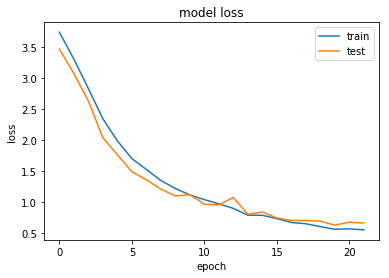

In [10]:
history = model.fit(X_train, y_train,
                    validation_split=0.25,
                    epochs=50,
                    batch_size=200,
                    verbose=1, callbacks=callbacks)
def plot(history):
    """ Plots model loss from model train history"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot(history)

# Evaluation of model

In [12]:
model.load_weights(checkpoint_path)

score = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-score[1]*100))
print("Loss: %.2f" % score[0])
print("Accuracy: %.2f%%" % (score[1]*100))

CNN Error: 17.57%
Loss: 0.61
Accuracy: 82.43%


The model displays an accuracy of 82.43% in the test set and 80.96% in the validation set.